# TP 8: Approximation des valeurs propres du Laplacien #


## 1. Introduction au calcul de valeurs propres ##
$\newcommand{\sca}[2]{\langle #1|#2\rangle}
\newcommand{\abs}[1]{|#1|}
\newcommand{\nr}[1]{\|#1\|}
\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\hdots}{\dots}$
Dans toutes la suite, on suppose que $A$ est une matrice diagonalisable sur $\Rsp$, de taille $N\times N$, $\lambda_1,\hdots \lambda_N$ sont ses valeurs propres et $w_1,\hdots,w_N$ est une base de vecteurs propres associés tels que $\nr{w_i} = 1$. 

**Q1.** (Méthode de la puissance) On suppose que $\abs{\lambda_N} > \abs{\lambda_i}$ pour tout $i\neq N$. Soit $x^{(0)} = \sum_i \alpha_i w_i \in\Rsp^N$ un vecteur tel que $\alpha_N \neq 0$. On définit une par récurrence $x^{(k+1)} = \dfrac{A x^{(k)}}{\nr{A x^{(k)}}}$. 

- Démontrer que pour tout $k\geq 1$, $x^{(k)} = \dfrac{(A^k x^{(0)})}{\nr{A^k x^{(0)}}}$.
- En déduire que 
$$
\begin{aligned}
&\lim_{k\to +\infty} \min(\nr{x^{(k)} - w_N}, \nr{x^{(k)} + w_N}) = 0 \\
& \lim_{k\to+\infty} \nr{A x^{(k)} - \lambda_N x^{(k)}} = 0
\end{aligned}$$

**Q2.** (Méthode de la puissance inverse) On suppose $0 < \abs{\lambda_1} < \abs{\lambda_i}$ pour tout $i\neq 1$. Soit $x^{(0)} = \sum_i \alpha_i w_i \in\Rsp^N$ tel que $\alpha_1 \neq 0$, et $x^{(k+1)} = \frac{A^{-1} x^{(k)}}{\nr{A^{-1} x^{(k)}}}$. Déduire de la question précédente que
$$
\begin{aligned}
&\lim_{k\to +\infty} \min(\nr{x^{(k)} - w_1}, \nr{x^{(k)} + w_1}) = 0 \\
& \lim_{k\to+\infty} \nr{A x^{(k)} - \lambda_1 x^{(k)}} = 0
%& \lim_{k\to+\infty} \sca{A^{-1} x^{(k)}}{x^{(k)}} = \frac{1}{\lambda_1}
\end{aligned}$$

**Q3.** Soit $B$ diagonalisable de vecteurs propres $\lambda_1,\hdots,\lambda_N$ et $\sigma\in\Rsp$ tel que $\exists i_0 \in \{1,\hdots,N\}$ vérifiant $\abs{\lambda_{i_0} - \sigma} < \abs{\lambda_i - \sigma}$ pour tout $i\neq i_0$. Montrer que la méthode de la puissance inverse appliquée à $A = B - \sigma \mathrm{I}_N$ permet d'approcher la valeur propre $\lambda_{i_0}$ et le vecteur propre associé.

**Q4.** Écrire une fonction `valeur_propre(B,sigma)` retournant la valeur propre de $B$ la plus proche de $\sigma$ et le vecteur propre associé.
- Pour estimer la valeur propre à l'étape $k$, on calculera $\lambda^{(k)} =\dfrac{ (A x^{(k)})_i} { (x^{(k)}_i)}$ où $i = \arg\max_{1\leq j\leq N} \abs{x^{(k)}_i}$.
- On interrompra les itérations dès que $\nr{A x^{(k)} - \lambda^{(k)} x^{(k)}} \leq 10^{-10}$

Tester le calcul avec la matrice $A$ et $\sigma = 0$, qui discrétise l'opposé du Laplacien 1D (avec conditions de Dirichlet), en différences finies, soit

$$ A = \frac{1}{h^2} \begin{pmatrix} 2 & -1 \\
-1 & 2 & 1 \\
& \ddots &\ddots & \ddots \\
& & -1 & 2 & -1\\
& & & -1 & 2 
\end{pmatrix},$$

où $h=1/(N+1)$. Les valeurs propres et vecteur propres de $A$ sont données par 
$\lambda_i = \frac{4}{h^2} \sin\left(\pi i h\right)^2$ et 
$(w_i)_j = \sin\left(\pi ij h \right)$ pour $1\leq i\leq j\leq N$. On pourra utiliser la fonction `np.linalg.eigh` pour calculer les autres valeurs propres et vérifier la convergence de l'algorithme vers d'autres valeurs propres.


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
% matplotlib inline

def valeur_propre(B,sigma):
    N = B.shape[0]
    x = np.random.rand(N)
    niter = 0
    A = B - sigma*np.eye(N)
    while True:
        xo = x.copy()
        x = np.linalg.solve(A,x)
        i = np.argmax(abs(x))
        lb = xo[i]/x[i]
        if np.linalg.norm(lb*x-xo) < 1e-10:
            break
        x = x/np.linalg.norm(x)
        niter += 1
    return lb+sigma,x,niter

N=10
h = 1.0/(N+1)
A = -(np.eye(N,N,-1) + np.eye(N,N,1) - 2*np.eye(N))/(h**2)

lb,x,niter = valeur_propre(A,0.)
v = np.sort(np.linalg.eig(A)[0])
print(lb)
print(v)


9.802700385444872
[  9.80270039  38.41664505  83.52370239 141.46956685 207.55980914
 276.44019086 342.53043315 400.47629761 445.58335495 474.19729961]


## 2. Formulation par éléments finis ## 

$$
\newcommand{\LL}{\mathrm{L}} 
\newcommand{\dd}{\mathrm{d}} 
\newcommand{\Psp}{\mathbb{P}}
$$
On s'intéresse à la recherche des valeurs propres du laplacien avec conditions de Neumann d'un ouvert $\Omega\subseteq \Rsp^2$ à bord régulier par la méthode des éléments finis en 2D, c'est-à-dire aux couples $(\lambda,w) \in \Rsp\times V$ où $V = H^1(\Omega)$ tels que

$$\forall v\in V, a(w,v) = \lambda \sca{w}{v}_{\LL^2(\Omega)}$$

où $a(u,v) = \sca{u}{v}_V = \int_\Omega (\sca{\nabla u}{\nabla v} + uv) \mathrm{d} x.$
Pour discrétiser le problème, on considère une famille de triangulation triangulation $T_h$ de $\Omega$, et on note:
* $V_h$ l'espace des éléments finis $\Psp_1$ sur $T_h$, de sorte que $V_h\subseteq V := H^1(\Omega)$;
* $N_h :=\dim(V_h) = $ nombre de sommets dans la triangulation ;
* $H := \LL^2(\Omega)$.

On rappelle enfin qu'un couple $(\lambda_h,w_h) \in \Rsp\times V_h$ est valeur propre du problème discret si

$$
\forall v_h\in V_h,\qquad a(w, v_h) = \lambda_{h} \sca{w_{h}}{v_h}_{H}.
$$



**Q1.** (Valeurs propres du problème continu) Justifier que les valeurs propres du laplacien (sur l'espace $V$) forment une suite croissante $0 < \lambda_1 \leq \lambda_2 \leq \hdots$ tendant vers l'infini.

Pour tout noeud $x_i$ (= sommet de la triangulation $T_h$), on note $\phi_i$ la fonction chapeau correspondante, i.e. l'unique fonction $\phi_i\in V_h$ telle que $\phi_i(x_j) = \delta_{i,j}$. On rappelle que les fonctions $(\phi_i)_{1\leq i\leq N_h}$ forment une base de l'espace $V_h$. 

**Q2.** (Valeurs propres du problème discret)
- Montrer que $\lambda\in \Rsp$ et $w = \sum_{i} W_i \phi_i\neq 0$ est un couple de valeur/vecteur propre pour le problème variationnel discret si et seulement si  $A W = \lambda B W$
où les matrice $A$ et $B$ sont à préciser. Montrer que ces matrices sont symétriques définies positives. 
- Montrer qu'il existe  une matrice $C$ triangulaire inférieure dont les éléments
diagonaux sont strictement positifs telle que $B = C C^T$.
- En déduire l'existence de $\lambda_{1,h}\leq \dots \leq \lambda_{N_h,h} \in \Rsp$ et de $W_{1,h},\dots,W_{N_h,h} \in \Rsp^N$ tels que $A W_{i,h} = \lambda_{i,h} B W$ et $\sca{W_{i,h}}{B W_{i,h}}_{\Rsp^{N_h}} = 0$.

On admet que le bord de $\Omega$ est suffisamment régulier pour que $C^\infty(\bar{\Omega})$ soit dense dans $H^1(\Omega)$ (il suffit par exemple que $\partial \Omega$ soit de bord $C^1$). De plus, on supposera l'existence d'un opérateur $r_h: C^2(\bar{\Omega})\to H^1(\Omega)$ tel que  pour toute fonction $v\in C^2(\bar{\Omega})$, $\lim_{h\to 0} \nr{r_h(v) - v}_{H^1(\Omega)} = 0.$ 

*(NB: Cela revient implicitement à faire une hypothèse sur la triangulation.)*

**Q3.** (Convergence des valeurs propres) Soit $V' \subseteq V$ un sous-espace vectoriel de dimension finie engendré par une famille orthonormale $w_1,\hdots,w_k\in V$.
- Démontrer que $\lim_{h\to 0} \max_{1\leq i\leq k} \dd(w_k,V_h) = 0, $
où l'on a posé $\dd(w,V_h) = \min_{v\in V_h} \nr{v-w}_V$.
- En décomposant $w\in W$ dans la base des $(w_i)_{1\leq i\leq k}$, prouver que 
$\max_{w \in V' \mid \nr{w} = 1} \dd(w,V_h) \leq \sqrt{k} \max_{1\leq i\leq k} \dd(w_k,V_h).$
- En utilisant un théorème du cours, en déduire que pour tout $k$, $\lim_{h\to 0} \lambda_{k,h} = \lambda_k$.


**Q4.** Construire les matrices $A$ et $B$ en Python pour une triangulation du carré $\Omega = [0,1]^2$, avec $h=1/30$ (reprendre le TP précédent). 
- Calculer la plus petite valeur propre et le vecteur propre associé en appliquant la fonction écrite dans le première partie à la matrice $B^{-1} A$. 
- Calculer et visualiser les vecteurs propres correspondant aux $k=10$ plus petites valeurs propres en utilisant la fonction `np.linalg.eig`.
- Comment évolue le nombre d'itération de l'algorithme utilisé dans `valeur_propre` lorsque sigma est proche d'une valeur propre multiple ? Justifier ce comportement.

11
[ 1.         10.87825926 10.87828544 20.79237407 40.61691802 40.61755204
 50.64284105 50.64601742 80.81239847 90.52879836]
valeurs propre 0: 1


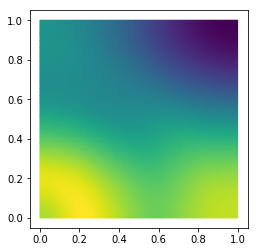

valeurs propre 1: 10.8783


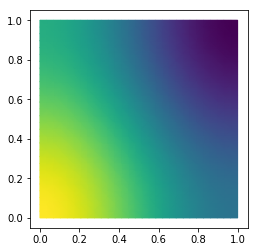

valeurs propre 2: 10.8783


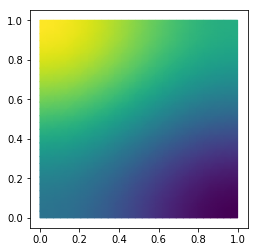

valeurs propre 3: 20.7924


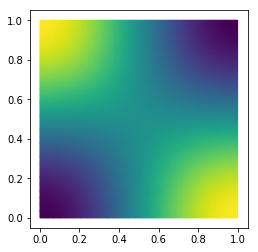

valeurs propre 4: 40.6169


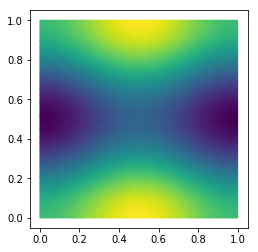

valeurs propre 5: 40.6176


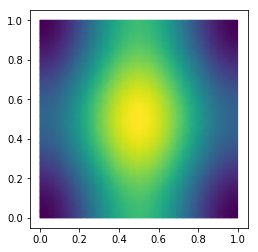

valeurs propre 6: 50.6428


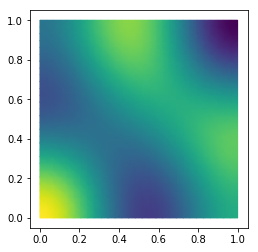

valeurs propre 7: 50.646


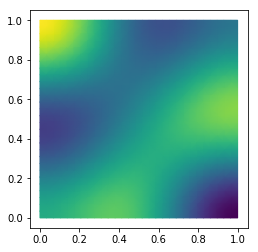

24
10.87828544052127


In [2]:
import matplotlib.tri as tri

def triangulation_carre(n):
    x,y = np.meshgrid(np.linspace(0.,1.,n),
                      np.linspace(0.,1.,n))
    x = x.reshape(n*n,1)
    y = y.reshape(n*n,1)
    X = np.hstack((x,y))
    T = tri.Triangulation(x.flatten(), y.flatten()).triangles
    return X,T

def M_elem(S1,S2,S3):
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0] 
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]
    D = ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    M=(1.*np.abs(D)/24)*np.ones([3,3])
    M[range(3),range(3)]=1.*np.abs(D)/12
    return M

def K_elem(S1,S2,S3):
    x1 = S1[0]
    y1 = S1[1]
    x2 = S2[0] 
    y2 = S2[1]
    x3 = S3[0]
    y3 = S3[1]
    norm = np.zeros([3, 2])
    norm[0, :] = np.array([y2-y3, x3-x2])
    norm[1, :] = np.array([y3-y1, x1-x3])
    norm[2, :] = np.array([y1-y2, x2-x1])
    D = ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    K = np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            K[i,j] = np.dot(norm[i,:],norm[j,:])
    return (1./(2*abs(D)))*K

def masse_et_rigidite(X,T):
    NSom = X.shape[0]
    NTri = T.shape[0]
    K = np.zeros([NSom,NSom])
    M = np.zeros([NSom,NSom])
    for N in range(0,NTri):
        S1=X[T[N,0],:]
        S2=X[T[N,1],:]
        S3=X[T[N,2],:]
        Kel=K_elem(S1, S2, S3)
        Mel=M_elem(S1, S2, S3)
        for i in range(0,3): 
            I = T[N,i]
            for j in range(0,3): 
                J = T[N,j]
                M[I,J] = M[I,J] + Mel[i,j]
                K[I,J] = K[I,J] + Kel[i,j]
    return M,K

X,T = triangulation_carre(30)
M,K = masse_et_rigidite(X,T)
A = K+M
B = M 
C = np.dot(np.linalg.inv(B),A)
ld1,w1,niter = valeur_propre(C,-1)
print(niter)

nvp=8
[w,psi] = np.linalg.eig(C)
print(np.sort(w)[0:10])
I = np.argsort(w)
for i in range(nvp):
    print("valeurs propre %d: %g" % (i, w[I[i]]))
    v = psi[:,I[i]]
    plt.tripcolor(X[:,0],X[:,1],T,v,shading='gouraud')
    plt.gca().set_aspect('equal')
    plt.show()
    
ld2,w2,niter = valeur_propre(C,10.8783)
print(niter)
print(ld2)

